In [1]:
# This script provides some reporting on the resolver data from identifiers.org
#
# Author: Manuel Bernal Llinares <mbdebian@gmail.com>

In [2]:
import time
import random
import pandas
import requests
import threading
import numpy as np
import multiprocessing as mp
import matplotlib.pyplot as plt
from collections import Counter
from multiprocessing import Pool
from multiprocessing.pool import ThreadPool

%matplotlib inline

In [3]:
# Endpoint from where the information is coming
identifiersorg_resolver_data_url = "https://identifiers.org/rest/collections/expand"
metadata_service_endpoint_from_url = "http://localhost:8082/getMetadataForUrl"

In [4]:
# Initialize pseudo-random number generator
random.seed(time.time())

In [5]:
# Helpers
def make_rest_request_content_type_json(url):
    # TODO - Magic number here!!!
    n_attempts = 42
    response = None
    while n_attempts:
        n_attempts -= 1
        try:
            response = requests.get(url, headers={"Content-Type": "application/json"})
        except Exception as e:
            # Any possible exception counts towards the attempt counter
            # Random wait - TODO - Another magic number!!!
            time.sleep(random.randint(30))
            continue
        if response.ok:
            return response.json()
        # Random wait - TODO - Another magic number!!!
        time.sleep(random.randint(10))
    response.raise_for_status()

In [6]:
def get_metadata_for_url(url):
    """
    This Helper queries the metadata service with a URL, 
    and returns its response back to the caller for further interpretation
    """
    n_attempts = 42
    response = None
    while n_attempts:
        n_attempts -= 1
        try:
            response = requests.post(metadata_service_endpoint_from_url, json={"url": url})
        except Exception as e:
            # Any possible exception counts towards the attempt counter
            # Random wait - TODO - Another magic number!!!
            time.sleep(random.randint(3))
            continue
        if response.ok:
            print("[METADATA][OK] - '{}'".format(url))
            break
        else:
            print("[METADATA][ERROR] - '{}'".format(url))
            break
        # Random wait - TODO - Another magic number!!!
    return response

In [7]:
# Get the resolver data
resolver_dump = make_rest_request_content_type_json(identifiersorg_resolver_data_url)

In [8]:
# Workout how many prefixes there are in identifiers.org
prefixes = [pid_entry['prefix'] for pid_entry in resolver_dump]

In [9]:
prefixes

['chebi',
 'ensembl',
 'ec-code',
 'uniprot',
 'taxonomy',
 'biomodels.db',
 'miriam.collection',
 'icd',
 'intact',
 'interpro',
 'kegg.pathway',
 'kegg.compound',
 'kegg.reaction',
 'pubmed',
 'omim',
 'pirsf',
 'reactome',
 'doi',
 'pdb',
 'go',
 'sgd',
 'sbo',
 'kegg.drug',
 'kegg.glycan',
 'wormbase',
 'pfam',
 'insdc',
 'flybase',
 'wormpep',
 'prosite',
 'pubchem.substance',
 'pubchem.compound',
 'arxiv',
 'arrayexpress',
 'mgi',
 'sabiork.reaction',
 'refseq',
 'tcdb',
 'uniparc',
 'mint',
 'dip',
 'signaling-gateway',
 'resid',
 'rgd',
 'tair.protein',
 'tair.gene',
 'tair.locus',
 'hmdb',
 'lipidmaps',
 'peptideatlas',
 'geo',
 'eco',
 'mod',
 'sgd.pathways',
 'biogrid',
 'merops',
 'panther.family',
 'prints',
 'ligandexpo',
 'aclame',
 'isbn',
 'pride',
 '3dmet',
 'fma',
 'matrixdb.association',
 'ncbigene',
 'kegg.genes',
 'brenda',
 'pubchem.bioassay',
 'pathwaycommons',
 'hovergen',
 'mmmp:biomaps',
 'wikipathways',
 'macie',
 'mirbase',
 'zfin',
 'hgnc',
 'so',
 'rhea',

In [10]:
print("There are #{} Compact ID prefixes registered in identifiers.org".format(len(prefixes)))

There are #629 Compact ID prefixes registered in identifiers.org


In [11]:
# Check the distribution of resources
resource_prefixes = []
for pid_entry in resolver_dump:
    if 'resources' in pid_entry:
        for resource in pid_entry['resources']:
            if 'resourcePrefix' in resource:
                resource_prefixes.append(resource['resourcePrefix'])
            else:
                print("NO RESOURCE PREFIX FOR: PID Entry Name '{}', Resource Information '{}'".format(pid_entry['name'], resource['info']))


NO RESOURCE PREFIX FOR: PID Entry Name 'Ensembl', Resource Information 'Ensembl US West mirror'
NO RESOURCE PREFIX FOR: PID Entry Name 'Ensembl', Resource Information 'Ensembl US East mirror'
NO RESOURCE PREFIX FOR: PID Entry Name 'Ensembl', Resource Information 'Ensembl Asia mirror'
NO RESOURCE PREFIX FOR: PID Entry Name 'Enzyme Nomenclature', Resource Information 'KEGG Ligand Database for Enzyme Nomenclature'
NO RESOURCE PREFIX FOR: PID Entry Name 'UniProt Knowledgebase', Resource Information 'Universal Protein Resource using Persistent URL system'
NO RESOURCE PREFIX FOR: PID Entry Name 'Taxonomy', Resource Information 'Taxonomy through UniProt PURL'
NO RESOURCE PREFIX FOR: PID Entry Name 'Taxonomy', Resource Information 'Bio2RDF'
NO RESOURCE PREFIX FOR: PID Entry Name 'BioModels Database', Resource Information 'Caltech mirror'
NO RESOURCE PREFIX FOR: PID Entry Name 'BioModels Database', Resource Information 'Bio2RDF'
NO RESOURCE PREFIX FOR: PID Entry Name 'ICD', Resource Information

In [12]:
#resource_prefixes

In [13]:
resource_prefixes_distribution = Counter(resource_prefixes)

In [14]:
resource_prefixes_distribution

Counter({'amigo': 2,
         'bptl': 34,
         'cpmc': 1,
         'ebi': 56,
         'enzymeportal': 1,
         'epmc': 2,
         'expasy': 2,
         'expenz': 1,
         'hubmed': 1,
         'intenz': 1,
         'ncbi': 33,
         'ols': 39,
         'pdbe': 1,
         'pdbj': 1,
         'quickgo': 2,
         'rcsb': 3,
         'sib': 1})

In [15]:
print("There #{} Resource Selectors in identifiers.org".format(len(resource_prefixes_distribution.keys())))

There #17 Resource Selectors in identifiers.org


In [16]:
labels = sorted(resource_prefixes_distribution.keys())
values = [resource_prefixes_distribution.get(key) for key in labels]

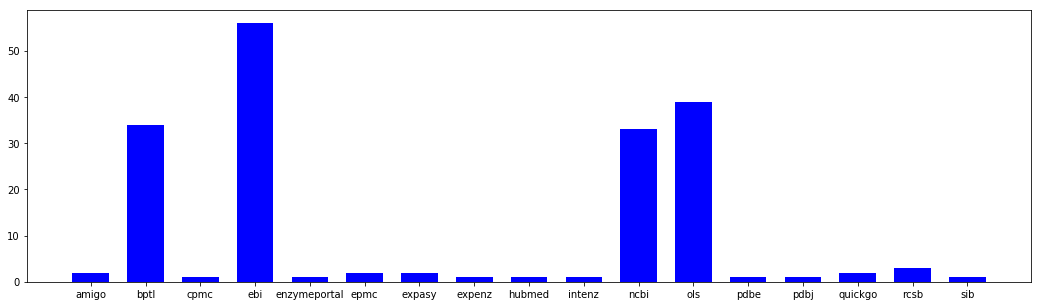

In [17]:
# I don't like this Pie Chart
fig1, ax1 = plt.subplots()
fig1.set_size_inches(18, 5)
ax1.bar(labels, values, 1/1.5, color="blue")
#ax1.pie(values, labels=labels, shadow=True, startangle=90)
#ax1.axis('equal')
plt.show()

In [18]:
# Create a report on metadata
columns = ['PidEntryName',
           'PidEntryPrefix',
           'PidEntryUrl', 
           'ResourceInfo', 
           'ResourceInstitution', 
           'ResourceLocation', 
           'ResourceOfficial', 
           'ResourcePrefix', 
           'ResourceLocalId', 
           'WasMetadataFound', 
           'MetadataContent', 
           'ResourceTestUrl', 
           'MetadataServiceResponseStatus', 
           'MetadataServiceResponseError']
metadata_report = pandas.DataFrame(columns=columns)

In [19]:
# Prepare the URLs and initial report (I could have done everything in one pass, but this is just investigating the dataset)
for pid_entry in resolver_dump:
    entry = pandas.Series(['---'] * len(columns), index=columns)
    entry.PidEntryName = pid_entry['name']
    entry.PidEntryPrefix = pid_entry['prefix']
    entry.PidEntryUrl = pid_entry['url']
    if ('resources' not in pid_entry) or (not pid_entry['resources']):
        metadata_report = metadata_report.append(entry, ignore_index=True)
    for resource in pid_entry['resources']:
        resource_entry = entry.copy()
        resource_entry.ResourceInfo = resource['info']
        resource_entry.ResourceInstitution = resource.get('institution', '---')
        resource_entry.ResourceLocation = resource.get('location', '---')
        resource_entry.ResourceOfficial = resource.get('official', '---')
        resource_entry.ResourcePrefix = resource.get('resourcePrefix', '---')
        resource_entry.ResourceLocalId = resource.get('localId', '---')
        resource_entry.WasMetadataFound = 'No'
        resource_entry.ResourceTestUrl = None
        if ('accessURL' in resource) and ('localId' in resource):
            resource_entry.ResourceTestUrl = resource['accessURL'].replace('{$id}', resource['localId'])
        metadata_report = metadata_report.append(resource_entry, ignore_index=True)        

In [20]:
metadata_report.ResourceTestUrl.describe()

count                                     761
unique                                    760
top       http://zfin.org/ZDB-GENO-980202-899
freq                                        2
Name: ResourceTestUrl, dtype: object

In [21]:
metadata_report.head()

,PidEntryName,PidEntryPrefix,PidEntryUrl,ResourceInfo,ResourceInstitution,ResourceLocation,ResourceOfficial,ResourcePrefix,ResourceLocalId,WasMetadataFound,MetadataContent,ResourceTestUrl,MetadataServiceResponseStatus,MetadataServiceResponseError
0,ChEBI,chebi,http://identifiers.org/chebi,ChEBI (Chemical Entities of Biological Interest),"European Bioinformatics Institute, Hinxton, Ca...",UK,True,ebi,36927,No,---,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,---,---
1,ChEBI,chebi,http://identifiers.org/chebi,ChEBI through OLS,"European Bioinformatics Institute, Hinxton, Ca...",UK,False,ols,36927,No,---,http://www.ebi.ac.uk/ols/ontologies/chebi/term...,---,---
2,ChEBI,chebi,http://identifiers.org/chebi,ChEBI through BioPortal,"National Center for Biomedical Ontology, Stanford",USA,False,bptl,36927,No,---,http://purl.bioontology.org/ontology/CHEBI/CHE...,---,---
3,Ensembl,ensembl,http://identifiers.org/ensembl,Ensembl at Sanger/EMBL-EBI,Sanger Institute and European Bioinformatics I...,UK,True,ebi,ENSG00000139618,No,---,http://www.ensembl.org/id/ENSG00000139618,---,---
4,Ensembl,ensembl,http://identifiers.org/ensembl,Ensembl US West mirror,---,USA,False,---,ENSG00000139618,No,---,http://uswest.ensembl.org/id/ENSG00000139618,---,---


In [22]:
# Parallel call to metadata service, this is a lot slower, good enough as proof of concept
#metadata_requests = {index: threading.Thread(target=get_metadata_for_url(metadata_report.loc[index].ResourceTestUrl)) for index in range(metadata_report.shape[0]) if metadata_report.loc[index].ResourceTestUrl}

# Parallel wrapper - Version using multiprocessing, it crashes within Jupyter
#def metadata_request_parallel_wrapper(context, url):
#    context.put(get_metadata_for_url(url))
#metadata_requests = {index: multiprocessing.Process(target=metadata_request_parallel_wrapper, args=(multiprocessing.Queue(), metadata_report.loc[index].ResourceTestUrl),) for index in range(metadata_report.shape[0]) if metadata_report.loc[index].ResourceTestUrl}
#metadata_requests = {index: multiprocessing.Process(target=get_metadata_for_url, args=(metadata_report.loc[index].ResourceTestUrl,)) for index in range(metadata_report.shape[0]) if metadata_report.loc[index].ResourceTestUrl}
#[process.start() for process in metadata_requests.values()]

# Another approach, with Thread Pool
pool = Pool(processes=mp.cpu_count() * 4)
indexes_to_process = [index for index in range(metadata_report.shape[0]) if metadata_report.loc[index].ResourceTestUrl]

[METADATA][ERROR] - 'http://linkedchemistry.info/chembl/chemblid/CHEMBL308052'
[METADATA][ERROR] - 'http://prodom.prabi.fr/prodom/current/cgi-bin/request.pl?question=DBEN&query=PD10000'
[METADATA][ERROR] - 'http://www.ebi.ac.uk/cgi-bin/dbfetch?db=uniparc&id=UPI000000000A'
[METADATA][ERROR] - 'http://www.3dmet.dna.affrc.go.jp/cgi/show_data.php?acc=B00162'
[METADATA][ERROR] - 'http://www.kegg.jp/entry/R00100'
[METADATA][ERROR] - 'http://www.kegg.jp/entry/syn:ssr3451'
[METADATA][ERROR] - 'http://smpdb.ca/view/SMP00001'
[METADATA][ERROR] - 'http://www.ebi.ac.uk/compneur-srv/LGICdb/HTML/5HT3Arano.php'
[METADATA][ERROR] - 'http://sgd.bio2rdf.org/describe/?url=http://bio2rdf.org/sgd:S000003909'
[METADATA][ERROR] - 'http://bidd.nus.edu.sg/group/TTD/ZFTTDDetail.asp?ID=TTDS00056'
[METADATA][ERROR] - 'http://ctdbase.org/detail.go?type=disease&db=MESH&acc=D053716'
[METADATA][ERROR] - 'http://www.whocc.no/atc_ddd_index/?code=A10BA02'
[METADATA][ERROR] - 'http://taxonomy.bio2rdf.org/describe/?url=ht

[METADATA][ERROR] - 'http://dip.doe-mbi.ucla.edu/dip/DIPview.cgi?ID=DIP-743N'
[METADATA][ERROR] - 'http://purl.bioontology.org/ontology/PATO/PATO:0001998'
[METADATA][ERROR] - 'http://pubmed.bio2rdf.org/describe/?url=http://bio2rdf.org/pubmed:23735196'
[METADATA][ERROR] - 'http://www.ebi.ac.uk/ols/ontologies/eco/terms?obo_id=ECO:0000006'
[METADATA][ERROR] - 'http://arabidopsis.org/servlets/TairObject?type=locus&name=AT1G01030'
[METADATA][ERROR] - 'http://purl.bioontology.org/ontology/CHEBI/CHEBI:36927'
[METADATA][ERROR] - 'http://pdbj.org/mine/summary/2gc4'
[METADATA][ERROR] - 'http://www.ncbi.nlm.nih.gov/nuccore/X58356'
[METADATA][ERROR] - 'http://thebiogrid.org/31623'
[METADATA][ERROR] - 'http://merops.sanger.ac.uk/cgi-bin/pepsum?mid=S01.001'
[METADATA][ERROR] - 'http://purl.bioontology.org/ontology/SBO/SBO:0000262'
[METADATA][ERROR] - 'http://www.kegg.jp/entry/D00123'
[METADATA][ERROR] - 'http://jjj.biochem.sun.ac.za/models/curien/'
[METADATA][ERROR] - 'http://www.ncbi.nlm.nih.gov/St

[METADATA][ERROR] - 'http://www.york.ac.uk/res/thomas/Gene.cfm?recordID=EB0170'
[METADATA][ERROR] - 'http://img.jgi.doe.gov/cgi-bin/w/main.cgi?section=GeneDetail&gene_oid=638309541'
[METADATA][OK] - 'http://www.cathdb.info/domain/1cukA01'
[METADATA][ERROR] - 'http://metazoa.ensembl.org/id/FBtr0084214'
[METADATA][ERROR] - 'http://doi.org/10.1038/nbt1156'
[METADATA][ERROR] - 'http://www.gramene.org/db/qtl/qtl_display?qtl_accession_id=CQG5'
[METADATA][ERROR] - 'http://www.genenames.org/cgi-bin/gene_symbol_report?hgnc_id=2674'
[METADATA][ERROR] - 'http://tritrypdb.org/tritrypdb/showRecord.do?name=GeneRecordClasses.GeneRecordClass&source_id=Tb927.8.620'
[METADATA][ERROR] - 'http://mycobrowser.epfl.ch/leprosysearch.php?gene+name=ML0224'
[METADATA][ERROR] - 'https://urgi.versailles.inra.fr/Genefarm/Gene/display_gene.htpl?GENE_ID=4892'
[METADATA][ERROR] - 'http://www.nextprot.org/db/entry/NX_O00165'
[METADATA][ERROR] - 'http://www.antweb.org/specimen.do?name=casent0106247'
[METADATA][ERROR] - 

[METADATA][ERROR] - 'http://www.conoserver.org/?page=card&table=protein&id=2639'
[METADATA][ERROR] - 'http://purl.bioontology.org/ontology/BTO/BTO:0000146'
[METADATA][ERROR] - 'http://umbbd.ethz.ch/servlets/pageservlet?ptype=ep&enzymeID=e0333'
[METADATA][ERROR] - 'http://www.ebi.ac.uk/miriam/main/resources/MIR:00100005'
[METADATA][ERROR] - 'http://purl.bioontology.org/ontology/PW/PW:0000208'
[METADATA][ERROR] - 'http://rna.igmors.u-psud.fr/NAPP/Niveau2.php?specie=351'
[METADATA][ERROR] - 'http://www.noncode.org/NONCODERv3/ncrna.php?ncid=377550'
[METADATA][ERROR] - 'http://www.ebi.ac.uk/ena/data/view/BP100000.1'
[METADATA][ERROR] - 'http://co.mbine.org/specifications/sbgn.er.level-1.version-1.2'
[METADATA][ERROR] - 'http://ncbigene.bio2rdf.org/describe/?url=http://bio2rdf.org/ncbigene:100010'
[METADATA][ERROR] - 'http://www.dpvweb.net/dpv/showdpv.php?dpvno=100'
[METADATA][ERROR] - 'http://homologene.bio2rdf.org/describe/?url=http://bio2rdf.org/homologene:1000'
[METADATA][ERROR] - 'http:

[METADATA][ERROR] - 'http://webapps2.ucalgary.ca/~groupii/cgi-bin/intron.cgi?name=Cu.me.I1'
[METADATA][ERROR] - 'http://pubchem.ncbi.nlm.nih.gov/summary/summary.cgi?sid=100101'
[METADATA][ERROR] - 'http://omabrowser.org/cgi-bin/gateway.pl?f=DisplayEntry&p1=HUMAN16963'
[METADATA][ERROR] - 'http://www.kegg.jp/entry/ev:E00032'
[METADATA][ERROR] - 'http://fungidb.org/gene/CNBG_0001'
[METADATA][ERROR] - 'http://bioinformatics.hsanmartino.it/hypercldb/cl3603.html'
[METADATA][ERROR] - 'http://darcsite.genzentrum.lmu.de/darc/view.php?id=1250'
[METADATA][ERROR] - 'http://www.proteinmodelportal.org/query/uniprot/Q0VCA6'
[METADATA][ERROR] - 'http://www.t3db.org/toxins/T3D0001'
[METADATA][ERROR] - 'http://www.ebi.ac.uk/ols/ontologies/obi/terms?obo_id=OBI:0000070'
[METADATA][ERROR] - 'http://antirrhinum.net/cgi-bin/ace/generic/tree/DragonDB?name=AMDEFA;class=Peptide'
[METADATA][ERROR] - 'http://bugs.sgul.ac.uk/bugsbase/tabs/protocol.php?protocol_id=67&amp;action=view'
[METADATA][ERROR] - 'http://ww

[METADATA][ERROR] - 'http://www.bioinfo.org/NONCODEv4/show_gene.php?id=NONHSAG00001'
[METADATA][ERROR] - 'http://www.bioinfo.org/NONCODEv4/show_rna.php?id=NONHSAT000001'
[METADATA][ERROR] - 'http://www.koehnlab.de/depod/showp.php?gene=PTPN1'
[METADATA][ERROR] - 'http://www.ebi.ac.uk/gxa/genes/AT4G01080'
[METADATA][ERROR] - 'http://www.ncbi.nlm.nih.gov/probe/?term=1000000'
[METADATA][ERROR] - 'http://dictybase.org/db/cgi-bin/feature_page.pl?primary_id=DDB0016567'
[METADATA][ERROR] - 'http://purl.bioontology.org/ontology/VARIO/VariO:0294'
[METADATA][ERROR] - 'http://www.ebi.ac.uk/ena/data/view/Taxon:9606'
[METADATA][ERROR] - 'http://func.mshri.on.ca/mouse/genes/list_functional_scores/1351341'
[METADATA][ERROR] - 'http://www.nlm.nih.gov/medlineplus/ency/article/002804.htm'
[METADATA][ERROR] - 'http://www.rcsb.org/pdb/ligand/ligandsummary.do?hetId=TRQ'
[METADATA][ERROR] - 'http://www.animalgenome.org/cgi-bin/QTLdb/OA/qdetails?QTL_ID=19803'
[METADATA][ERROR] - 'http://bgee.unil.ch/bgee/bgee

[METADATA][ERROR] - 'http://mona.fiehnlab.ucdavis.edu/#/spectra/splash/splash10-0zq2000000-77302b0326a418630a84'
[METADATA][ERROR] - 'http://e-cyanobacterium.org/models/model/26/'
[METADATA][ERROR] - 'http://www.genenames.org/genefamilies/PADI'
[METADATA][ERROR] - 'http://intron.ucsc.edu/cgi-bin/yeast4.3/intronreports.pl?outputformat=full&amp;orfName=SNR17A'
[METADATA][ERROR] - 'http://www.animalgenome.org/cgi-bin/QTLdb/GG/qdetails?QTL_ID=14362'
[METADATA][ERROR] - 'http://piroplasmadb.org/piro/showRecord.do?name=GeneRecordClasses.GeneRecordClass&source_id=TA14985'
[METADATA][ERROR] - 'https://polbase.neb.com/polymerases/19-T4#sequences'
[METADATA][ERROR] - 'http://www.humanproteomemap.org/spectrum.php?pep_id=9606117'
[METADATA][ERROR] - 'https://bioportal.bioontology.org/ontologies/MP/MP:0005452'
[METADATA][ERROR] - 'http://pharminfo.pharm.kyoto-u.ac.jp/services/glida/gpcr_information.php?id=ACM1_HUMAN'
[METADATA][ERROR] - 'http://www.receptors.org/nucleardb/proteins/prgr_human'
[META

[METADATA][ERROR] - 'https://portal.gdc.cancer.gov/cases/ae8c77fe-e6c8-44d5-8265-4a38c637bbef'
[METADATA][ERROR] - 'http://rnacentral.org/rna/URS0000759CF4'
[METADATA][ERROR] - 'http://www.informatics.jax.org/searches/Phat.cgi?id=MP:0005452'
[METADATA][ERROR] - 'http://data.europa.eu/89h/jrc-eurl-ecvam-chemagora'
[METADATA][ERROR] - 'https://mmp.sfb.uit.no/databases/marcat/#/records/MMP743597.11'
[METADATA][ERROR] - 'https://genelab-data.ndc.nasa.gov/genelab/accession/GLDS-141'
[METADATA][ERROR] - 'https://medical-data-models.org/forms/4776'
[METADATA][ERROR] - 'http://bioportal.bioontology.org/ontologies/BAO/bao:BAO_0002989'
[METADATA][ERROR] - 'https://neurovault.org/images/58788'
[METADATA][ERROR] - 'http://www.proteinatlas.org/ENSG00000026508'
[METADATA][ERROR] - 'http://pax-db.org/#!protein/977869'
[METADATA][ERROR] - 'https://www.ebi.ac.uk/ols/ontologies/omit/terms?short_form=OMIT_0005506'
[METADATA][ERROR] - 'https://herv.img.cas.cz/s/THE1B'
[METADATA][ERROR] - 'http://www.ebi.a

In [23]:
metadata_requests = pool.map(get_metadata_for_url, metadata_report.ResourceTestUrl[indexes_to_process])

In [27]:
for (index, response) in zip(indexes_to_process, metadata_requests):
    if response.ok:
        metadata_report.loc[index].WasMetadataFound = 'Yes'
        metadata_report.loc[index].MetadataContent = response.json()['metadata']
        print("[METADATA][OK] - '{}'".format(metadata_report.loc[index].ResourceTestUrl))
    else:
        print("[METADATA][ERROR] - '{}'".format(metadata_report.loc[index].ResourceTestUrl))
    if 'errorMessage' in response.json():
        metadata_report.loc[index].MetadataServiceResponseError = response.json()['errorMessage']
    else:
        metadata_report.loc[index].MetadataServiceResponseError = "METADATA SERVICE ERROR"
        print("[METADATA][QUERY_ERROR] - '{}', response '{}'".format(metadata_report.loc[index].ResourceTestUrl, response.json()))
    metadata_report.loc[index].MetadataServiceResponseStatus = response.status_code

[METADATA][ERROR] - 'http://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:36927'
[METADATA][ERROR] - 'http://www.ebi.ac.uk/ols/ontologies/chebi/terms?obo_id=CHEBI:36927'
[METADATA][ERROR] - 'http://purl.bioontology.org/ontology/CHEBI/CHEBI:36927'
[METADATA][ERROR] - 'http://www.ensembl.org/id/ENSG00000139618'
[METADATA][ERROR] - 'http://uswest.ensembl.org/id/ENSG00000139618'
[METADATA][QUERY_ERROR] - 'http://uswest.ensembl.org/id/ENSG00000139618', response '{'timestamp': 1518964798136, 'status': 500, 'error': 'Internal Server Error', 'exception': 'java.lang.OutOfMemoryError', 'message': 'GC overhead limit exceeded', 'path': '/getMetadataForUrl'}'
[METADATA][ERROR] - 'http://useast.ensembl.org/id/ENSG00000139618'
[METADATA][QUERY_ERROR] - 'http://useast.ensembl.org/id/ENSG00000139618', response '{'timestamp': 1518964945779, 'status': 500, 'error': 'Internal Server Error', 'exception': 'java.lang.OutOfMemoryError', 'message': 'Java heap space', 'path': '/getMetadataForUrl'}'
[METADATA][E

[METADATA][ERROR] - 'http://www.ecogene.org/gene/EG10173'
[METADATA][ERROR] - 'http://www.gabipd.org/database/cgi-bin/GreenCards.pl.cgi?BioObjectId=2679240&Mode=ShowBioObject'
[METADATA][ERROR] - 'http://greengenes.lbl.gov/cgi-bin/show_one_record_v2.pl?prokMSA_id=100000'
[METADATA][QUERY_ERROR] - 'http://greengenes.lbl.gov/cgi-bin/show_one_record_v2.pl?prokMSA_id=100000', response '{'timestamp': 1518966440755, 'status': 500, 'error': 'Internal Server Error', 'exception': 'com.gargoylesoftware.htmlunit.FailingHttpStatusCodeException', 'message': '404 Not Found for http://greengenes.lbl.gov/cgi-bin/show_one_record_v2.pl?prokMSA_id=100000', 'path': '/getMetadataForUrl'}'
[METADATA][ERROR] - 'http://www.ars-grin.gov/cgi-bin/npgs/html/taxon.pl?19333'
[METADATA][ERROR] - 'http://h-invitational.jp/hinv/spsoup/locus_view?hix_id=HIX0004394'
[METADATA][ERROR] - 'http://h-invitational.jp/hinv/spsoup/transcript_view?hit_id=HIT000195363'
[METADATA][ERROR] - 'http://h-invitational.jp/hinv/protein/pr

[METADATA][ERROR] - 'http://merops.sanger.ac.uk/cgi-bin/pepsum?id=I31.952'
[METADATA][QUERY_ERROR] - 'http://merops.sanger.ac.uk/cgi-bin/pepsum?id=I31.952', response '{'timestamp': 1518968389700, 'status': 500, 'error': 'Internal Server Error', 'exception': 'java.lang.ClassCastException', 'message': 'java.lang.String cannot be cast to net.sourceforge.htmlunit.corejs.javascript.Function', 'path': '/getMetadataForUrl'}'
[METADATA][ERROR] - 'http://animaldiversity.ummz.umich.edu/accounts/Lycalopex_vetulus/'
[METADATA][QUERY_ERROR] - 'http://animaldiversity.ummz.umich.edu/accounts/Lycalopex_vetulus/', response '{'timestamp': 1518968649585, 'status': 500, 'error': 'Internal Server Error', 'exception': 'java.lang.OutOfMemoryError', 'message': 'GC overhead limit exceeded', 'path': '/getMetadataForUrl'}'
[METADATA][ERROR] - 'http://pharminfo.pharm.kyoto-u.ac.jp/services/glida/gpcr_information.php?id=ACM1_HUMAN'
[METADATA][ERROR] - 'http://pharminfo.pharm.kyoto-u.ac.jp/services/glida/ligand_inf

In [28]:
metadata_report.head()

,PidEntryName,PidEntryPrefix,PidEntryUrl,ResourceInfo,ResourceInstitution,ResourceLocation,ResourceOfficial,ResourcePrefix,ResourceLocalId,WasMetadataFound,MetadataContent,ResourceTestUrl,MetadataServiceResponseStatus,MetadataServiceResponseError
0,ChEBI,chebi,http://identifiers.org/chebi,ChEBI (Chemical Entities of Biological Interest),"European Bioinformatics Institute, Hinxton, Ca...",UK,True,ebi,36927,No,---,http://www.ebi.ac.uk/chebi/searchId.do?chebiId...,400,FAILED to fetch metadata for URL 'http://www.e...
1,ChEBI,chebi,http://identifiers.org/chebi,ChEBI through OLS,"European Bioinformatics Institute, Hinxton, Ca...",UK,False,ols,36927,No,---,http://www.ebi.ac.uk/ols/ontologies/chebi/term...,400,FAILED to fetch metadata for URL 'http://www.e...
2,ChEBI,chebi,http://identifiers.org/chebi,ChEBI through BioPortal,"National Center for Biomedical Ontology, Stanford",USA,False,bptl,36927,No,---,http://purl.bioontology.org/ontology/CHEBI/CHE...,400,FAILED to fetch metadata for URL 'http://purl....
3,Ensembl,ensembl,http://identifiers.org/ensembl,Ensembl at Sanger/EMBL-EBI,Sanger Institute and European Bioinformatics I...,UK,True,ebi,ENSG00000139618,No,---,http://www.ensembl.org/id/ENSG00000139618,400,FAILED to fetch metadata for URL 'http://www.e...
4,Ensembl,ensembl,http://identifiers.org/ensembl,Ensembl US West mirror,---,USA,False,---,ENSG00000139618,No,---,http://uswest.ensembl.org/id/ENSG00000139618,500,METADATA SERVICE ERROR


In [29]:
# Dump report to file
metadata_report.to_csv('metadata_report.csv', encoding='utf-8')